# Table of Contents

### Stage 1 - Prep the data
* [Step 1.) Import necessary libraries and adjust display settings](#Step1)
* [Step 2.) Create yearly player performance dataframe by combining files](#Step2)
        - Load in raw data
        - Filter year range
        - Drop duplicate records from when players change team 
        - Clean player names
* [Step 3.) Create draft history dataframe](#Step3)
        - Load in raw data
        - Filter year range
        - Identify rare issues where primary key (player name) are identical
        - Utilize Levenshtein match scores to match player name keys between draft dataframe and yearly stats dataframe
        - Replace player names using dictionary created above
* [Step 4.) Create 2023-2024 Player Salary dataframe](#Step4)
        - Load in raw data
        - Clean data
        
### Stage 2 - Analyze the Data and Answer Questions

* [Question 1.) Which Player in the last 10 years had the highest WS/48 in one season (min of 60 games played)? In which year?](#Question1)
* [Question 2.) Which player in the last 10 years played the most minutes in a single season after playing in all 82 games? In which year?](#Question2)
* [Question 3.) FUTURE WORK](#Question3)
* [Question 4.) Which draft pick positions provide the best value?](#Question4)
* [Question 5.) Biggest number one pick draft bust from 2003-2018? How about for each overall draft position?](#Question5)
* [Question 6.) Which player represents the average player for each pick position?](#Question6)
* [Question 7.) For players that have played at least 10 years, on average which age did they peak?](#Question7)
* [Question 8.) Which players were most underpaid and overpaid players in 2023-2024?](#Question8)

### Stage 3 - Dynamically Export dataframes of interest created in Stages 1 and 2 to their own Excel worksheets within the source Excel Workbook
* [Part 1.) Create the appropriately named worksheets within the source Excel Workbook](#Stage3Step1)
* [Part 2.) Write the dataframes and their data to the newly created worksheets](#Stage3Step1)

# Stage 1 - Prep the Data

## Import necessary libraries and adjust display settings <a class="anchor" id="Step1"></a>

In [1]:
import os as os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import itertools
from openpyxl import load_workbook
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.4f}'.format
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt 

# Create list of dataframes and dataframe names
list_of_dataframes = []
list_of_dataframe_names = []

## Create a singular dataframe containing player stats since 2003. <a class="anchor" id="Step2"></a>

### Load in dataframes dynamically from a folder, drop duplicate records from where players changed teams in season, assign year value, and append to master dataframe 

In [2]:
yearly_player_stats_folder_path = f'{os.getcwd()}\\Yearly Player Stats'

master_df_list = []

cumulative_row_counter = 0

for file_name in os.listdir(yearly_player_stats_folder_path):
    
    # Assign season value
    year = file_name.split(' ')[0]
    
    # Create dataframe name
    dataframe_name = f'_{file_name.split(".")[0].lower().replace(" ","_")}_df'
    
    # Store dataframe globally with specified name
    globals()[dataframe_name] = pd.read_csv(f'{yearly_player_stats_folder_path}\\{file_name}')
    
    # Drop Duplicate Player Records Created from When Players Change Teams in season
    globals()[dataframe_name].drop_duplicates('Player',keep='first',inplace=True)
    
    # Add a Year Column and assign to year
    globals()[dataframe_name]['Year'] = int(year)
    
    # Append to master_df_list
    master_df_list.append(globals()[dataframe_name]) 
    
    # Cumulative_row_counter
    cumulative_row_counter = cumulative_row_counter + len(globals()[dataframe_name])

## 

In [3]:
# Concat all dataframes into one
yearly_player_stats_df = pd.concat(master_df_list)

# Verify that total record count of master dataframe matches the cumulative record count of the original dataframes
if len(yearly_player_stats_df)!=cumulative_row_counter:
    raise Exception('Record count of master dataframe does not match cumulative count of component dataframes')
    
# Reset indices
yearly_player_stats_df.reset_index(drop=True,inplace=True)

# Strip * from player name
yearly_player_stats_df['Player'] = yearly_player_stats_df['Player'].str.rstrip('*')

# Append dataframe to list of dataframe
list_of_dataframes.append(yearly_player_stats_df)
list_of_dataframe_names.append('Yearly Player Stats')

# Create a dataframe including year = 2023 for one of the questions we're answering
yearly_player_stats_df_2023_included = yearly_player_stats_df

# Create a df excluding year = 2023 because the season is not finished
yearly_player_stats_df = yearly_player_stats_df.loc[yearly_player_stats_df['Year']!=2023]

## Create a singular dataframe containing draft history data since 2003. <a class="anchor" id="Step3"></a>

### Filter for date range of 2003-2018 and address potential issues regarding using Player Names as keys between dataframes

In [4]:
# Read in raw draft history data
draft_history_df = pd.read_csv('draft_history.csv')

# Filter to 2003 Draft and Onward, but cut off year at 2018. This way, we have at least 4 years of data on picks
draft_history_df=draft_history_df.loc[(draft_history_df['season']>2002)&(draft_history_df['season']<2019)]

### We're using player names as keys between tables, so check to make sure all player names are unique

In [5]:
# Identify 3 cases of different individuals with identical names
for player in draft_history_df['player_name'].unique():
    
    length_of_df = len(draft_history_df.loc[draft_history_df['player_name']==player])
    
    if length_of_df > 1:
        
        print(player)
        
# Three cases exist: Marcus Williams, Justin Jackson, and Marcus Thornton. In each case, only 1 of the 2 actually played 
# in the NBA. Just need to identify which one when populating dataframe.

Marcus Williams
Marcus Thornton
Justin Jackson


### Player names are different between databases because one is plain text and one contains accented characters. Use Levenshtein string matching to recommend and export best matches for review

In [6]:
# Create blank dataframe to append closest player name matches too for export to Excel
player_name_dict_df = pd.DataFrame()
player_name_dict_df[['Player Name from Draft History','Player Name from Yearly Player History Data','Match Ratio']] = np.nan

# For each player name in draft_history, compare to all the player names in the yearly player stats dataframe and find closest match
for player in draft_history_df['player_name']:
    
    # If player name not found in player stat df, find closest match
    if player not in yearly_player_stats_df['Player'].unique():
        
        best_match_ratio = 0
        
        best_match = ''
        
        for player_name in yearly_player_stats_df['Player'].unique():
            
            # Calculate match ratio
            match_ratio = fuzz.ratio(player,player_name)
            
            # If match is best match found so far, rewrite it as best match
            if match_ratio > best_match_ratio:
                
                best_match = player_name
                
                best_match_ratio = match_ratio
                
        # Write final best match info to dataframe
        player_name_dict_df.loc[len(player_name_dict_df.index)] = player,best_match,best_match_ratio

# Export to Excel for review
player_name_dict_df.to_excel('Possible Dictionary Matches.xlsx')

### After confirming matches in Excel, replace player names using dictionary of approved player name matches. 

#### Note: Some drafted players never played an NBA game, so will these players will not be found in the yearly stats dataframe.

In [7]:
# These are two unique cases found manually before using Levenshtein matching to increase speed of matching
name_replacement_dict = {'Rafael Araujo':'Rafael Araújo','Ha Ha':'Ha Seung-Jin'}
draft_history_df['player_name'] = draft_history_df['player_name'].replace(name_replacement_dict)

# After Levenshtein matching review, load Excel back in and replace player names using dictionary of manually-approved matches
reviewed_player_name_dict_df = pd.read_excel('Possible Dictionary Matches Reviewed.xlsx')
reviewed_player_name_dict_df = reviewed_player_name_dict_df.loc[reviewed_player_name_dict_df['Match?']=='Yes']
name_replacement_dict = dict(zip(reviewed_player_name_dict_df['Player Name from Draft History'],reviewed_player_name_dict_df['Player Name from Yearly Player History Data']))
draft_history_df['player_name'] = draft_history_df['player_name'].replace(name_replacement_dict)

In [8]:
# Append dataframe to list of dataframe
list_of_dataframes.append(draft_history_df)
list_of_dataframe_names.append('Draft History')

## Load in data containing 2023-2024 Player Salaries from Contract Data <a class="anchor" id="Step4">

In [9]:
# Read in raw data
player_salary_df = pd.read_csv('2023 Player Contracts.txt')

# Filter out Rudy Gay who isn't get paid this year
player_salary_df = player_salary_df.loc[player_salary_df['2023-24'].notnull()]

# Strip $ from string 
player_salary_df['2023-24'] = player_salary_df['2023-24'].str.lstrip('$')

# Convert string to int
player_salary_df['2023-24'] = player_salary_df['2023-24'].astype(int)

player_salary_df

#player_salary_df.loc[player_salary_df['2023-24'].notnull()]
#player_salary_df['2023-24'][0].lstrip('$').astype(int) #= player_salary_df['2023-24']

,Rk,Player,Tm,2023-24,2024-25,2025-26,2026-27,2027-28,2028-29,Guaranteed,-9999
0,1,Stephen Curry,GSW,51915615,$55761216,$59606817,NaN,NaN,NaN,$167283648,curryst01
1,2,Kevin Durant,PHO,47649433,$51179021,$54708609,NaN,NaN,NaN,$153537063,duranke01
2,3,Nikola Jokić,DEN,47607350,$51415938,$55224526,$59033114,$62841702,NaN,$213280928,jokicni01
3,4,Joel Embiid,PHI,47607350,$51415938,$55224526,$59033114,NaN,NaN,$154247814,embiijo01
4,5,LeBron James,LAL,47607350,$51415938,NaN,NaN,NaN,NaN,$47607350,jamesle01
5,6,Bradley Beal,PHO,46741590,$50203930,$53666270,$57128610,NaN,NaN,$150611790,bealbr01
6,7,Giannis Antetokounmpo,MIL,45640084,$48787676,$68302746,$73766966,$79231186,NaN,$236497472,antetgi01
7,8,Damian Lillard,MIL,45640084,$48787676,$58545211,$63228828,NaN,NaN,$152972971,lillada01
8,9,Kawhi Leonard,LAC,45640084,NaN,NaN,NaN,NaN,NaN,$45640084,leonaka01
9,10,Paul George,LAC,45640084,$48787676,NaN,NaN,NaN,NaN,$45640084,georgpa01


In [10]:
# Append dataframe to list of dataframe
list_of_dataframes.append(player_salary_df)
list_of_dataframe_names.append('Player Salary')

## FUTURE WORK - Load in data containing last 10 years of NBA standings

# Stage 2 - Analyze Data and Answer Questions

## Question 1: 

## Which Player in the last 10 years had the highest WS/48 in one season (min of 60 games played)? In which year? <a class="anchor" id="Question1"></a>

In [11]:
last_10_years_df = yearly_player_stats_df.loc[(yearly_player_stats_df['Year']>2012)&(yearly_player_stats_df['G']>60)]

last_10_years_df = last_10_years_df.sort_values('WS/48',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(last_10_years_df)
list_of_dataframe_names.append('Best Single Season Performance')

In [43]:
last_10_years_df

,Rk,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,...,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Player-additional,Year
5633,105,Stephen Curry,PG,27,GSW,79,2700,31.5000,0.6690,0.5540,...,4.1000,17.9000,0.3180,NaN,10.3000,1.6000,11.9000,9.5000,curryst01,2015
9483,249,Nikola Jokić,C,27,DEN,69,2323,31.5000,0.7010,0.1460,...,3.8000,14.9000,0.3080,NaN,8.5000,4.5000,13.0000,8.8000,jokicni01,2022
8352,263,Nikola Jokić,C,25,DEN,72,2488,31.3000,0.6470,0.1830,...,3.4000,15.6000,0.3010,NaN,9.1000,3.0000,12.1000,8.8000,jokicni01,2020
8919,290,Nikola Jokić,C,26,DEN,74,2476,32.8000,0.6610,0.2200,...,4.5000,15.2000,0.2960,NaN,9.2000,4.5000,13.7000,9.8000,jokicni01,2021
4689,134,Kevin Durant,SF,25,OKC,81,3122,29.8000,0.6350,0.2910,...,4.4000,19.2000,0.2950,NaN,8.8000,1.4000,10.2000,9.6000,duranke01,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6195,191,Mario Hezonja,SF,21,ORL,65,960,7.2000,0.4500,0.4360,...,0.8000,-0.7000,-0.0330,NaN,-4.1000,-0.9000,-5.0000,-0.7000,hezonma01,2016
4714,159,Diante Garrett,PG,25,UTA,71,1048,7.1000,0.4590,0.3620,...,0.3000,-0.8000,-0.0360,NaN,-4.0000,-0.6000,-4.6000,-0.7000,garredi02,2013
5966,438,Rashad Vaughn,SG,19,MIL,70,1001,4.2000,0.3980,0.5530,...,0.4000,-0.8000,-0.0360,NaN,-4.4000,-1.3000,-5.7000,-0.9000,vaughra01,2015
7286,256,Josh Jackson,SG,21,PHO,79,1988,10.6000,0.4870,0.2680,...,1.1000,-1.7000,-0.0400,NaN,-3.3000,-1.2000,-4.6000,-1.3000,jacksjo02,2018


## Question 2:

## Which player in the last 10 years played the most minutes in a single season after playing in all 82 games? In which year? <a class="anchor" id="Question2"></a>

In [12]:
#last_10_years_df.sort_values('TS%',ascending=False)
most_minutes_df = last_10_years_df.sort_values('MP',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(most_minutes_df)
list_of_dataframe_names.append('Most Minutes Played Season')

In [13]:
print(f'James Harden plays {3125/82} minutes per game!')

James Harden plays 38.109756097560975 minutes per game!


## FUTURE WORK - Question 3: 

## How much does age impact expected total win shares? How has Lebron's last few years compared to the average for his ages? <a class="anchor" id="Question3"></a>

In [14]:
## Question 3: How much does age impact expected total win shares? How has Lebron's last few years compared to the average for his ages? 

## Question 4: 

## Historic Value of Draft Picks <a class="anchor" id="Question4"></a>

### Create and populate draft_turnout dataframe with the info of how each draft pick turned out by combining draft history info with player stat info

In [15]:
# Create dataframe to append info to
draft_turnout_df = pd.DataFrame()
draft_turnout_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# For player in 2003 Draft dataframe, populate draft turnout dataframe with their data
identical_name_list = ['Justin Jackson','Marcus Williams','Marcus Thornton']
marcus_williams_counter = 0
justin_jackson_counter = 0
marcus_thornton_counter = 0

# Iterate through players in draft history and pull out their stats to populate draft turnout dataframe
for player in draft_history_df['player_name']:
    
    ## SPECIAL CASES: IDENTICAL NAME/KEYS HANDLING ##
    if player in identical_name_list:
        
        ## Marcus Williams Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Marcus Williams' and marcus_williams_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0
            
        # First encounter will be the Marcus Williams that played, treat as normal
        if player == 'Marcus Williams' and marcus_williams_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            marcus_williams_counter = 1
            
        ## Justin Jackson Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Justin Jackson' and justin_jackson_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0  
        
        # First encounter will be the Justin Jackson that played, treat as normal
        if player == 'Justin Jackson' and justin_jackson_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            justin_jackson_counter = 1
            
        ## Marcus Thornton Handling ##
        
        # Second encounter will be the Marcus Williams that did not play, treat as DNP
        if player == 'Marcus Thornton' and marcus_thornton_counter == 1:
        
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[1]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0
        
        # First encounter will be the Justin Jackson that played, treat as normal
        if player == 'Marcus Thornton' and marcus_thornton_counter == 0:
            
            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years
            
            # Set counter
            marcus_thornton_counter = 1
            
    ## IF NOT IDENTICAL NAME, TREAT AS NORMAL ##
    
    if player not in identical_name_list:
    
        ## RETURN TO NORMAL CASE LOGIC ##
        if player in yearly_player_stats_df['Player'].unique():

            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Determine Total Win Shares the First 4 Years in the league
            first_four_year_df = yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player].sort_values('Year',ascending=True).head(4)
            total_win_share_first_four_years = first_four_year_df['WS'].sum()

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,total_win_share_first_four_years

        if player not in yearly_player_stats_df['Player'].unique():

            # Grab draft position
            index = draft_history_df.loc[draft_history_df['player_name']==player].index[0]
            draft_position = draft_history_df['overall_pick'][index]

            # Grab year drafted
            year_drafted = draft_history_df['season'][index]

            # Populate dataframe
            draft_turnout_df.loc[len(draft_turnout_df.index)] = player,draft_position,year_drafted,0


In [16]:
draft_turnout_df.sort_values('Total Win Shares the First 4 Years',ascending=False).head(5)

,Player,Overall Pick,Year Drafted,Total Win Shares the First 4 Years
120,Chris Paul,4,2005,55.3000
0,LeBron James,1,2003,49.4000
657,Karl-Anthony Towns,1,2015,45.4000
357,Blake Griffin,1,2009,41.8000
4,Dwyane Wade,5,2003,38.8000


In [17]:
# Append dataframe to list of dataframe
list_of_dataframes.append(draft_turnout_df)
list_of_dataframe_names.append('Draft Player Turnout')

## Determine Average Total Win Shares by Draft Position and then Plot

In [18]:
pick_value_vs_avg_win_share_df = pd.DataFrame()
pick_value_vs_avg_win_share_df[['Overall Pick','Median Total Win Shares the First 4 Years in League']] = np.nan

for pick_value in draft_turnout_df['Overall Pick'].unique():
    
    # Filter dataframe on pick_value
    pick_value_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_value]
    
    # Calculate Average Total Win Shares
    average_total_win_share = pick_value_df['Total Win Shares the First 4 Years'].median()
    
    # Populate dataframe
    pick_value_vs_avg_win_share_df.loc[len(pick_value_vs_avg_win_share_df.index)] = pick_value,average_total_win_share

In [19]:
pick_value_vs_avg_win_share_df.to_excel('Pick Value Table.xlsx')
pick_value_vs_avg_win_share_df.head(15)

,Overall Pick,Median Total Win Shares the First 4 Years in League
0,1.0000,26.5000
1,2.0000,9.6000
2,3.0000,17.7000
3,4.0000,14.1000
4,5.0000,13.2000
5,6.0000,11.1000
6,7.0000,13.6000
7,8.0000,7.3000
8,9.0000,12.7000
9,10.0000,6.3000


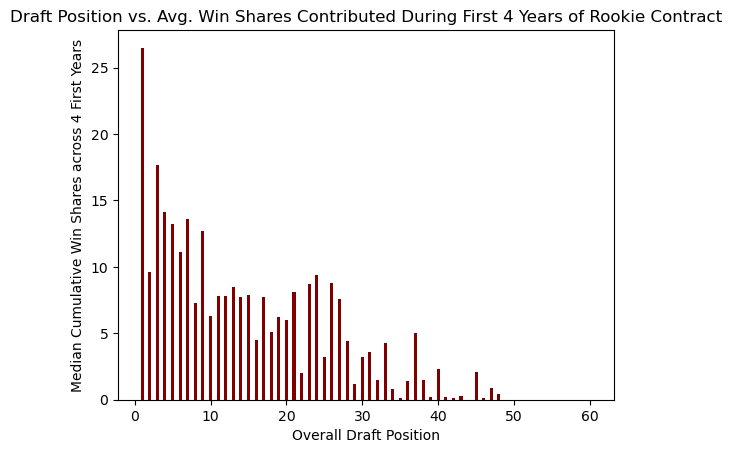

In [20]:
plt.bar(pick_value_vs_avg_win_share_df['Overall Pick'], pick_value_vs_avg_win_share_df['Median Total Win Shares the First 4 Years in League'], color ='maroon', 
        width = 0.4)

plt.xlabel("Overall Draft Position")
plt.ylabel("Median Cumulative Win Shares across 4 First Years")
plt.title("Draft Position vs. Avg. Win Shares Contributed During First 4 Years of Rookie Contract")
plt.show()

In [21]:
# Append dataframe to list of dataframe
list_of_dataframes.append(pick_value_vs_avg_win_share_df)
list_of_dataframe_names.append('Pick position median values')

## Question 5:

## Biggest number one pick draft bust from 2003-2018? How about for each overall draft position? <a class="anchor" id="Question5"></a>

In [22]:
pick_value = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==1]
pick_value = pick_value.sort_values('Total Win Shares the First 4 Years',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(pick_value)
list_of_dataframe_names.append('Number one pick success')

pick_value

,Player,Overall Pick,Year Drafted,Total Win Shares the First 4 Years
597,Anthony Bennett,1,2013,0.5000
777,Markelle Fultz,1,2017,3.1000
237,Greg Oden,1,2007,7.3000
177,Andrea Bargnani,1,2006,11.4000
117,Andrew Bogut,1,2005,16.9000
417,John Wall,1,2010,18.1000
837,Deandre Ayton,1,2018,24.6000
477,Kyrie Irving,1,2011,26.5000
297,Derrick Rose,1,2008,30.0000
717,Ben Simmons,1,2016,30.3000


In [23]:
worst_player_by_pick_position_df = pd.DataFrame()
worst_player_by_pick_position_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# Iterate through pick position and pull out data for the median win-share player for that position and append to dataframe
for pick_position in draft_turnout_df['Overall Pick'].unique():
    
    # Grab dataframe at pick position
    pick_position_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_position]
    
    # Display median value of win shares at that pick position. If multiple mins (shared value), grab just the first
    pick_position_df = pick_position_df.loc[pick_position_df['Total Win Shares the First 4 Years']==pick_position_df['Total Win Shares the First 4 Years'].min()].head(1)
    
    # Append data to newly created dataframe by concat
    worst_player_by_pick_position_df = pd.concat([worst_player_by_pick_position_df,pick_position_df])

worst_player_by_pick_position_df = worst_player_by_pick_position_df.sort_values('Overall Pick',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(worst_player_by_pick_position_df)
list_of_dataframe_names.append('Bust by draft position')

worst_player_by_pick_position_df

,Player,Overall Pick,Year Drafted,Total Win Shares the First 4 Years
597,Anthony Bennett,1.0000,2013.0000,0.5000
1,Darko Miličić,2.0000,2003.0000,4.1000
179,Adam Morrison,3.0000,2006.0000,-1.5000
780,Josh Jackson,4.0000,2017.0000,-1.8000
661,Mario Hezonja,5.0000,2015.0000,2.4000
362,Jonny Flynn,6.0000,2009.0000,-1.1000
663,Emmanuel Mudiay,7.0000,2015.0000,-1.1000
65,Rafael Araújo,8.0000,2004.0000,-0.4000
785,Dennis Smith Jr.,9.0000,2017.0000,-1.0000
67,Luke Jackson,10.0000,2004.0000,0.2000


## Question 6:

## Median Player for Each Overall Pick Position <a class="anchor" id="Question6"></a>

In [24]:
median_player_by_pick_position_df = pd.DataFrame()
median_player_by_pick_position_df[['Player','Overall Pick','Year Drafted','Total Win Shares the First 4 Years']] = np.nan

# Iterate through pick position and pull out data for the median win-share player for that position and append to dataframe
for pick_position in draft_turnout_df['Overall Pick'].unique():
    
    # Grab dataframe at pick position
    pick_position_df = draft_turnout_df.loc[draft_turnout_df['Overall Pick']==pick_position]
    
    # Display median value of win shares at that pick position. If multiple medians (shared value), grab just the first
    pick_position_df = pick_position_df.loc[pick_position_df['Total Win Shares the First 4 Years']==pick_position_df['Total Win Shares the First 4 Years'].median()].head(1)
    
    # Append data to newly created dataframe by concat
    median_player_by_pick_position_df = pd.concat([median_player_by_pick_position_df,pick_position_df])
    
median_player_by_pick_position_df = median_player_by_pick_position_df.sort_values('Overall Pick',ascending=True)

# Append dataframe to list of dataframe
list_of_dataframes.append(median_player_by_pick_position_df)
list_of_dataframe_names.append('Median Player by Pick Position')

median_player_by_pick_position_df

,Player,Overall Pick,Year Drafted,Total Win Shares the First 4 Years
477,Kyrie Irving,1.0000,2011.0000,26.5000
538,Michael Kidd-Gilchrist,2.0000,2012.0000,9.6000
599,Otto Porter Jr.,3.0000,2013.0000,17.7000
360,Tyreke Evans,4.0000,2009.0000,14.1000
781,De'Aaron Fox,5.0000,2017.0000,13.2000
5,Chris Kaman,6.0000,2003.0000,11.1000
843,Wendell Carter Jr.,7.0000,2018.0000,13.6000
244,Brandan Wright,8.0000,2007.0000,7.3000
365,DeMar DeRozan,9.0000,2009.0000,12.7000
726,Thon Maker,10.0000,2016.0000,6.3000


## Question 7: 

## For players that have played at least 10 years, on average which age did they peak? <a class="anchor" id="Question7"></a>

In [25]:
list_of_players_with_10_years_plus_exp = []

# Identify list of players with 10+ years of experience from the last 20 years of NBA data

for player in yearly_player_stats_df['Player'].unique():
    
    # See how many years of data exist for them
    years_played = len(yearly_player_stats_df.loc[yearly_player_stats_df['Player']==player])
    
    if years_played > 9:
        list_of_players_with_10_years_plus_exp.append(player)


In [26]:
# Create and populate dataframe with each player with 10+ years of experience showing only their "peak year"
peak_df = pd.DataFrame()
peak_df[['Player','Year','Age','Win Shares / 48 Minutes']] = ''

for player in list_of_players_with_10_years_plus_exp:
    
    # Look at their data
    temporary_df = yearly_player_stats_df.loc[(yearly_player_stats_df['Player']==player)&(yearly_player_stats_df['G']>50)]
    
    # Grab index where win shares is greatest
    max_index = temporary_df['WS/48'].idxmax()
    
    # Define year
    year_value = temporary_df['Year'][max_index]
    
    # Define age
    age_value = temporary_df['Age'][max_index]
    
    # Define Total Win Shares
    win_share_value = temporary_df['WS/48'][max_index]
    
    # Add values to dataframe
    peak_df.loc[len(peak_df.index)]=player,year_value,age_value,win_share_value
    
# Win Shares Per 48
average_age = peak_df['Age'].mean()
print(f'Average age of peak win shares contributed is {average_age}')
peak_df = peak_df.sort_values('Win Shares / 48 Minutes',ascending=False)

# Append dataframe to list of dataframe
list_of_dataframes.append(peak_df)
list_of_dataframe_names.append('Player Peaks')

peak_df

Average age of peak win shares contributed is 26.662251655629138


,Player,Year,Age,Win Shares / 48 Minutes
45,LeBron James,2012,28,0.3220
215,Stephen Curry,2015,27,0.3180
173,Kevin Durant,2013,25,0.2950
285,Giannis Antetokounmpo,2018,24,0.2920
140,Chris Paul,2008,23,0.2920
221,James Harden,2017,28,0.2890
67,Dirk Nowitzki,2006,28,0.2780
248,Jimmy Butler,2022,33,0.2770
254,Kawhi Leonard,2015,24,0.2770
271,Anthony Davis,2014,21,0.2740


## Question 8:

## Evaluating underpaid and overpaid players in 2023-2024 <a class="anchor" id="Question8"></a>



In [27]:
# Create dataframe 
player_salary_vs_performance_df = pd.DataFrame()
player_salary_vs_performance_df[['Player','2023-2024 Salary','Total Win Shares So Far']] = np.nan

# Populate dataframe
for player in player_salary_df['Player'].unique():
    
    if player not in yearly_player_stats_df_2023_included['Player'].unique():
        
        print(player)
        
    else:
    
        # Grab 2023 salary
        index = player_salary_df.loc[player_salary_df['Player']==player].index[0]
        player_salary = player_salary_df['2023-24'][index]
        
        # Grab total_win_shares if player played, if didn't play win share = 0
        length_of_dataframe = len(yearly_player_stats_df_2023_included.loc[(yearly_player_stats_df_2023_included['Player']==player)&(yearly_player_stats_df_2023_included['Year']==2023)&(yearly_player_stats_df_2023_included['G']>20)])
        
        if length_of_dataframe>0:
        
            # Grab 2023 win shares
            index = yearly_player_stats_df_2023_included.loc[(yearly_player_stats_df_2023_included['Player']==player)&(yearly_player_stats_df_2023_included['Year']==2023)&(yearly_player_stats_df_2023_included['G']>20)].index[0]
            total_win_shares = yearly_player_stats_df_2023_included['WS'][index]
            
            # Populate dataframe
            player_salary_vs_performance_df.loc[len(player_salary_vs_performance_df.index)] = player,player_salary,total_win_shares
    
player_salary_vs_performance_df.sort_values('Total Win Shares So Far',ascending=False)

# Create column that is Win Shares/Dollar
player_salary_vs_performance_df['Dollar/Win Shares'] = player_salary_vs_performance_df['2023-2024 Salary']/player_salary_vs_performance_df['Total Win Shares So Far']

player_salary_vs_performance_df = player_salary_vs_performance_df.sort_values('Dollar/Win Shares',ascending=False)
 
# Export to Excel
player_salary_vs_performance_df.to_excel('Player Salary vs Performance.xlsx')

player_salary_vs_performance_df


,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares
223,Gradey Dick,4536720,0.0000,inf
328,Anthony Gill,1997238,0.0000,inf
350,Julian Phillips,1600000,0.0000,inf
304,Luka Šamanić,2066585,0.0000,inf
193,Jevon Carter,6190476,0.0000,inf
346,Jaden Hardy,1719864,0.0000,inf
292,Yuta Watanabe,2346614,0.0000,inf
59,Jordan Clarkson,23487629,0.3000,78292096.6667
39,Gordon Hayward,31500000,0.5000,63000000.0000
208,Davion Mitchell,5063640,0.1000,50636400.0000


In [28]:
def salary_categorizer(salary)->'str':
    
    if salary>0 and salary<5000000:
        salary_value = 'Under 5M'

    if salary>=5000000 and salary<10000000:
        salary_value = 'Between 5M and 10M'

    if salary>=10000000 and salary<20000000:
        salary_value = 'Between 10M and 20M'

    if salary>=20000000 and salary<30000000:
        salary_value = 'Between 20M and 30M'

    if salary>=30000000 and salary<40000000:
        salary_value = 'Between 30M and 40M'

    if salary>=40000000 and salary<60000000:
        salary_value = 'Between 40M and 60M'

        
    return salary_value

player_salary_vs_performance_df['Salary Category'] = player_salary_vs_performance_df['2023-2024 Salary'].apply(salary_categorizer)

# Append dataframe to list of dataframe
list_of_dataframes.append(player_salary_vs_performance_df)
list_of_dataframe_names.append('Underpaid and Overpaid')

player_salary_vs_performance_df

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
223,Gradey Dick,4536720,0.0000,inf,Under 5M
328,Anthony Gill,1997238,0.0000,inf,Under 5M
350,Julian Phillips,1600000,0.0000,inf,Under 5M
304,Luka Šamanić,2066585,0.0000,inf,Under 5M
193,Jevon Carter,6190476,0.0000,inf,Between 5M and 10M
346,Jaden Hardy,1719864,0.0000,inf,Under 5M
292,Yuta Watanabe,2346614,0.0000,inf,Under 5M
59,Jordan Clarkson,23487629,0.3000,78292096.6667,Between 20M and 30M
39,Gordon Hayward,31500000,0.5000,63000000.0000,Between 30M and 40M
208,Davion Mitchell,5063640,0.1000,50636400.0000,Between 5M and 10M


### Top and worst performers in under 5M range

In [29]:
category_of_interest = 'Under 5M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
227,Tyrese Maxey,4343920,5.7000,762091.2281,Under 5M
248,Alperen Şengün,3536280,5.6000,631478.5714,Under 5M
221,Jalen Williams,4558680,4.4000,1036063.6364,Under 5M


In [30]:
category_of_interest = 'Under 5M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
259,Malaki Branham,3071880,-0.4000,-7679700.0000,Under 5M
316,Ish Smith,2019706,-0.4000,-5049265.0000,Under 5M
283,Nick Smith Jr.,2463960,-0.3000,-8213200.0000,Under 5M


### Top and worst performers in between 5M and 10M range

In [31]:
category_of_interest = 'Between 5M and 10M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
197,Tyrese Haliburton,5808435,5.9000,984480.5085,Between 5M and 10M
151,Isaiah Hartenstein,9245121,4.8000,1926066.8750,Between 5M and 10M
162,Scottie Barnes,8008680,4.0000,2002170.0000,Between 5M and 10M


In [32]:
category_of_interest = 'Between 5M and 10M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
144,Scoot Henderson,9770880,-1.2000,-8142400.0000,Between 5M and 10M
209,Johnny Davis,5050800,-0.2000,-25254000.0000,Between 5M and 10M
193,Jevon Carter,6190476,0.0000,inf,Between 5M and 10M


### Top and worst performers in between 10M and 20M range

In [33]:
category_of_interest = 'Between 10M and 20M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
136,Chet Holmgren,10386000,5.4000,1923333.3333,Between 10M and 20M
88,Lauri Markkanen,17259999,5.4000,3196296.1111,Between 10M and 20M
96,Jonas Valančiūnas,15435000,5.3000,2912264.1509,Between 10M and 20M


In [34]:
category_of_interest = 'Between 10M and 20M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
132,Brandon Miller,10880400,0.3000,36268000.0000,Between 10M and 20M
126,Cade Cunningham,11055360,0.4000,27638400.0000,Between 10M and 20M
138,Landry Shamet,10250000,0.4000,25625000.0000,Between 10M and 20M


### Top and worst performers in between 20M and 30M range

In [35]:
category_of_interest = 'Between 20M and 30M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
50,Jalen Brunson,26346666,6.9000,3818357.3913,Between 20M and 30M
72,Jarrett Allen,20000000,6.0000,3333333.3333,Between 20M and 30M
55,Mike Conley,24360000,5.0000,4872000.0000,Between 20M and 30M


In [36]:
category_of_interest = 'Between 20M and 30M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
47,Jordan Poole,27455357,-0.9000,-30505952.2222,Between 20M and 30M
52,Kyle Kuzma,25568182,-0.1000,-255681820.0000,Between 20M and 30M
59,Jordan Clarkson,23487629,0.3000,78292096.6667,Between 20M and 30M


### Top and worst performers in between 30M and 40M range

In [37]:
category_of_interest = 'Between 30M and 40M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
31,Shai Gilgeous-Alexander,33386850,10.8000,3091375.0000,Between 30M and 40M
41,Domantas Sabonis,30600000,7.2000,4250000.0000,Between 30M and 40M
36,Jayson Tatum,32600060,6.3000,5174612.6984,Between 30M and 40M


In [38]:
category_of_interest = 'Between 30M and 40M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
39,Gordon Hayward,31500000,0.5000,63000000.0000,Between 30M and 40M
28,Darius Garland,34005250,1.2000,28337708.3333,Between 30M and 40M
37,Deandre Ayton,32459438,1.9000,17083914.7368,Between 30M and 40M


### Top and worst performers in between 40M and 60M range

In [39]:
category_of_interest = 'Between 40M and 60M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=False).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
2,Nikola Jokić,47607350,10.6000,4491259.4340,Between 40M and 60M
6,Giannis Antetokounmpo,45640084,8.5000,5369421.6471,Between 40M and 60M
12,Rudy Gobert,41000000,7.1000,5774647.8873,Between 40M and 60M


In [40]:
category_of_interest = 'Between 40M and 60M'
player_salary_vs_performance_df.loc[player_salary_vs_performance_df['Salary Category']==category_of_interest].sort_values('Total Win Shares So Far',ascending=True).head(3)

,Player,2023-2024 Salary,Total Win Shares So Far,Dollar/Win Shares,Salary Category
5,Bradley Beal,46741590,1.3000,35955069.2308,Between 40M and 60M
11,Klay Thompson,43219440,1.3000,33245723.0769,Between 40M and 60M
17,Zach LaVine,40064220,1.5000,26709480.0000,Between 40M and 60M


# Stage 3 - Export dataframes to Excel <a class="anchor" id="Stage3Step1"></a>

In [41]:
## Create a copy of Template Sheet and Rename 
wb = load_workbook('NBA Analysis Output.xlsx')

for dataframe_name in list_of_dataframe_names:
    
    ## Assign desired sheet name
    desired_sheet_name = dataframe_name

    ## Create a Copy of Template Sheet
    wb.copy_worksheet(wb['Template Sheet'])

    ## Rename template sheet to desired
    wb['Template Sheet Copy'].title = desired_sheet_name
    

## Save changes to file
wb.save('NBA Analysis Output.xlsx')

In [42]:
index_count = 0

for dataframe in list_of_dataframes:
    
    print(index_count)
    
    ## DEFINE DESIRED SHEET NAME
    desired_sheet_name = list_of_dataframe_names[index_count]

    ## Write to newly created sheet 
    with pd.ExcelWriter('NBA Analysis Output.xlsx', engine='openpyxl', mode='a',if_sheet_exists='overlay') as writer:

        ## Write the new DataFrame to a new sheet
        dataframe.to_excel(writer, sheet_name=desired_sheet_name, index=False)
        
    ## Change index counter
    index_count = index_count + 1
    
## Save changes to file
writer.close

0
1
2
3
4
5
6
7
8
9
10
11


<bound method ExcelWriter.close of <pandas.io.excel._openpyxl.OpenpyxlWriter object at 0x00000268D3A4E3A0>>